# Autoregressive Models

## Imports

In [1]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from datetime import date
import geopandas as gpd
from IPython.display import display, HTML
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from utils import load_pkl, generate_times
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from metrics import *

from preprocessing import normalize

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Loading Data

### Contour Iris

In [2]:
contour_iris = gpd.read_file(
    '../datasets/iris/iris.shp')

convert_to_int = ['dep', 'insee_com', 'iris', 'code_iris']
for col in convert_to_int:
    contour_iris[col] = contour_iris[col].astype(int)

contour_iris = contour_iris[['code_iris', 'geometry', 'dep']]
contour_iris.head();

### Stations and Dates

In [3]:
station_data = pd.read_csv("../datasets/station_to_iris.csv")
station_data.describe();

In [4]:
stations_mode = load_pkl("../datasets/stations_mode.pkl")
subway_stations = [k for k, v in stations_mode.items() if v == 3]
print("Number of Subway stations: {}".format(len(subway_stations)))

Number of Subway stations: 303


Subways stations with less than $80000$ validations per $3$ month. Note that this is before we normalize the data. In the article, they removed $3$ subways stations, assuming that it was closed for renovation work. We printed below the $4$ stations with smaller number of validations.

In [5]:
station_data[(station_data['id'].isin(subway_stations)) & (station_data['validations_count'] < 80000)];

In [6]:
dates = pd.date_range(start="2015-10-01", end="2015-12-31").date

### Discretized Matrix

In [7]:
matrix_6h = np.load("../datasets/6h_matrix.npy")
matrix_2h = np.load("../datasets/2h_matrix.npy")
matrix_15m = np.load("../datasets/15m_matrix.npy")

## Data Analysis and Preprocessing

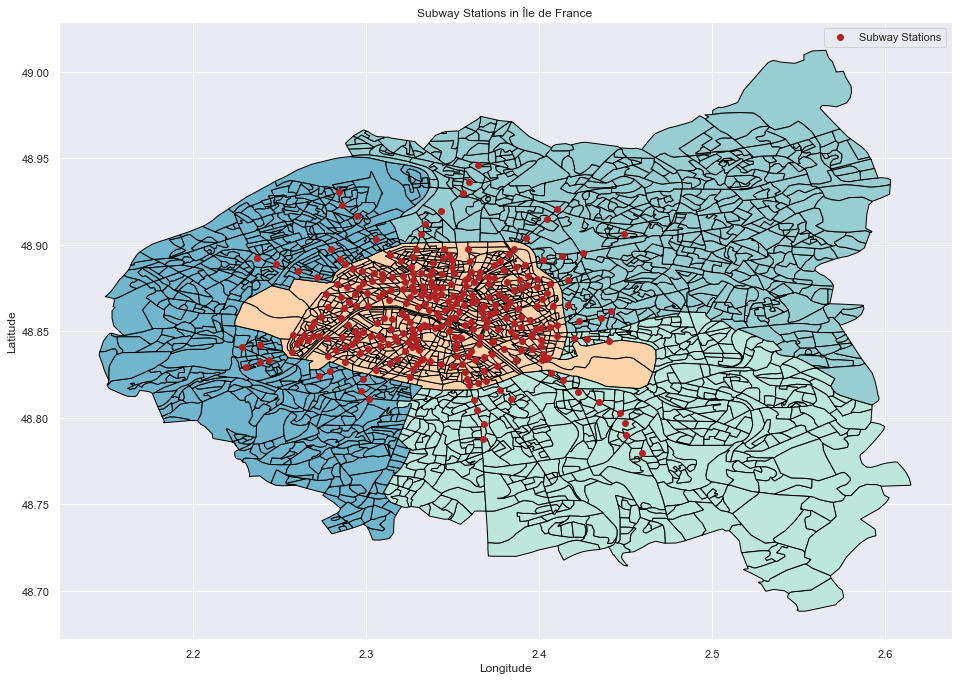

In [8]:
f, ax = plt.subplots(1, figsize=(16, 12))
ax = contour_iris[contour_iris['dep'].isin([75, 92, 93, 94])].plot(
    ax=ax, edgecolor='black', column='dep', cmap='icefire_r')
ax.scatter(station_data[station_data['id'].isin(subway_stations)]['x'],
           station_data[station_data['id'].isin(subway_stations)]['y'], color='firebrick', label='Subway Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Subway Stations in Île de France')
ax.legend()

plt.show();

### Min Max Normalization

Below we apply ``Min Max Normalization`` to data, with a scale range of $[0, 1]$.

In [9]:
data_matrix_6h = pd.Panel(normalize(matrix_6h), 
                         items=dates, 
                         major_axis=subway_stations, 
                         minor_axis=generate_times("6h")
                        )

data_matrix_2h = pd.Panel(normalize(matrix_2h), 
                         items=dates, 
                         major_axis=subway_stations, 
                         minor_axis=generate_times("2h")
                        )

data_matrix_15m_complete = pd.Panel(matrix_15m, 
                                    items=dates, 
                                    major_axis=subway_stations, 
                                    minor_axis=generate_times("15min")
                                   )

Delete the first $4$ hours, from $00.00.00$ to $04.00.00$ because it's useless, the number of validations in that range is mostly equal to 0.

In [10]:
del_hours = 5

In [11]:
data_matrix_15m = data_matrix_15m_complete.iloc[:, :, del_hours*4:]

In [12]:
data_matrix_15m.to_frame().head()

2015-10-01  2015-10-02  2015-10-03  2015-10-04  2015-10-05  \
major minor                                                                  
198   05:00:00         7.0        11.0         6.0        12.0        10.0   
      05:15:00        42.0        60.0        43.0        39.0        46.0   
      05:30:00        44.0        45.0        34.0        35.0        36.0   
      05:45:00        54.0        48.0        33.0        25.0        47.0   
      06:00:00        78.0        79.0        39.0        22.0        69.0   

                2015-10-06  2015-10-07  2015-10-08  2015-10-09  2015-10-10  \
major minor                                                                  
198   05:00:00         6.0         9.0        12.0         9.0        13.0   
      05:15:00        33.0        52.0        40.0        50.0        52.0   
      05:30:00        49.0        35.0        42.0        42.0        62.0   
      05:45:00        49.0        42.0        53.0        49.0        37.0   
      06:00:00        76.0        75.0        67.0        69.0        49.0   

                   ...      2015-12-22  2015-12-23  2015-12-24  2015-12-25  \
major minor        ...                                                       
198   05:00:00     ...            11.0         9.0         7.0         1.0   
      05:15:00     ...            45.0        44.0        32.0        13.0   
      05:30:00     ...            41.0        38.0        23.0         2.0   
      05:45:00     ...            34.0        44.0        35.0         6.0   
      06:00:00     ...            72.0        65.0        31.0         4.0   

                2015-12-26  2015-12-27  2015-12-28  2015-12-29  2015-12-30  \
major minor                                                                  
198   05:00:00         5.0        10.0        12.0        10.0        10.0   
      05:15:00        36.0        24.0        34.0        40.0        26.0   
      05:30:00        18.0        22.0        45.0        31.0        30.0   
      05:45:00        30.0        25.0        32.0        42.0        34.0   
      06:00:00        46.0        24.0        60.0        70.0        75.0   

                2015-12-31  
major minor                 
198   05:00:00         5.0  
      05:15:00        40.0  
      05:30:00        21.0  
      05:45:00        43.0  
      06:00:00        54.0  

[5 rows x 92 columns]

In [13]:
dmatrix_mean_6h = data_matrix_6h.mean()
dmatrix_mean_2h = data_matrix_2h.mean()
dmatrix_mean_15m = data_matrix_15m.mean()

dtmatrix_mean_6h = dmatrix_mean_6h.transpose()
dtmatrix_mean_2h = dmatrix_mean_2h.transpose()
dtmatrix_mean_15m = dmatrix_mean_15m.transpose()

Again, this is another way to print the stations with a small number of validations.

In [14]:
data_matrix_15m.mean(axis=0)[data_matrix_15m.mean(axis=0).sum(axis=1) < 810];

In [15]:
dmatrix_mean_15m.head()
dtmatrix_mean_15m.head()

2015-10-01  2015-10-02  2015-10-03  2015-10-04  2015-10-05  \
05:00:00    2.643564    3.079208    2.458746    3.900990    2.973597   
05:15:00   19.864686   22.399340   14.254125   15.920792   20.858086   
05:30:00   31.471947   34.537954   20.429043   19.696370   32.630363   
05:45:00   31.874587   34.650165   19.184818   16.963696   32.729373   
06:00:00   40.541254   41.858086   22.465347   16.247525   39.689769   

          2015-10-06  2015-10-07  2015-10-08  2015-10-09  2015-10-10  \
05:00:00    3.112211    3.293729    3.468647    3.254125    2.732673   
05:15:00   21.353135   21.409241   21.976898   22.580858   14.488449   
05:30:00   34.742574   34.587459   33.844884   34.650165   21.633663   
05:45:00   33.726073   34.986799   35.514851   36.636964   21.346535   
06:00:00   42.630363   42.940594   43.620462   40.709571   23.990099   

             ...      2015-12-22  2015-12-23  2015-12-24  2015-12-25  \
05:00:00     ...        2.696370    3.207921    2.920792    1.217822   
05:15:00     ...       20.884488   22.194719   20.630363    6.706271   
05:30:00     ...       33.270627   33.105611   31.198020    9.141914   
05:45:00     ...       32.234323   34.184818   31.392739    8.980198   
06:00:00     ...       40.828383   38.118812   34.425743   10.610561   

          2015-12-26  2015-12-27  2015-12-28  2015-12-29  2015-12-30  \
05:00:00    2.019802    1.795380    2.805281    2.993399    3.112211   
05:15:00   10.858086    8.207921   20.369637   19.580858   19.729373   
05:30:00   15.617162   11.831683   29.382838   30.363036   29.349835   
05:45:00   14.277228   11.514851   26.808581   28.726073   28.009901   
06:00:00   17.316832   13.504950   30.168317   33.072607   30.247525   

          2015-12-31  
05:00:00    2.798680  
05:15:00   19.660066  
05:30:00   28.201320  
05:45:00   27.679868  
06:00:00   29.933993  

[5 rows x 92 columns]

05:00:00   05:15:00   05:30:00   05:45:00   06:00:00   06:15:00  \
2015-10-01  2.643564  19.864686  31.471947  31.874587  40.541254  48.481848   
2015-10-02  3.079208  22.399340  34.537954  34.650165  41.858086  50.056106   
2015-10-03  2.458746  14.254125  20.429043  19.184818  22.465347  24.531353   
2015-10-04  3.900990  15.920792  19.696370  16.963696  16.247525  17.610561   
2015-10-05  2.973597  20.858086  32.630363  32.729373  39.689769  52.072607   

             06:30:00   06:45:00    07:00:00    07:15:00    ...      \
2015-10-01  66.980198  83.894389  125.099010  184.508251    ...       
2015-10-02  68.287129  85.666667  127.524752  172.877888    ...       
2015-10-03  26.745875  28.478548   37.821782   48.861386    ...       
2015-10-04  16.574257  16.574257   19.966997   24.042904    ...       
2015-10-05  74.518152  87.603960  131.656766  177.980198    ...       

             21:30:00   21:45:00   22:00:00   22:15:00   22:30:00   22:45:00  \
2015-10-01  70.927393  66.881188  65.399340  60.584158  60.755776  64.207921   
2015-10-02  78.590759  73.495050  70.907591  65.983498  66.211221  62.917492   
2015-10-03  82.211221  77.181518  73.755776  72.805281  74.570957  76.264026   
2015-10-04  43.570957  43.818482  41.745875  37.462046  36.722772  37.283828   
2015-10-05  61.039604  52.346535  53.125413  46.059406  45.498350  41.036304   

             23:00:00   23:15:00   23:30:00   23:45:00  
2015-10-01  75.128713  64.590759  52.138614  43.818482  
2015-10-02  66.330033  63.188119  57.755776  54.673267  
2015-10-03  83.947195  80.049505  76.587459  72.772277  
2015-10-04  52.759076  37.158416  31.211221  25.254125  
2015-10-05  41.254125  35.336634  28.003300  22.801980  

[5 rows x 76 columns]

### With Outliers

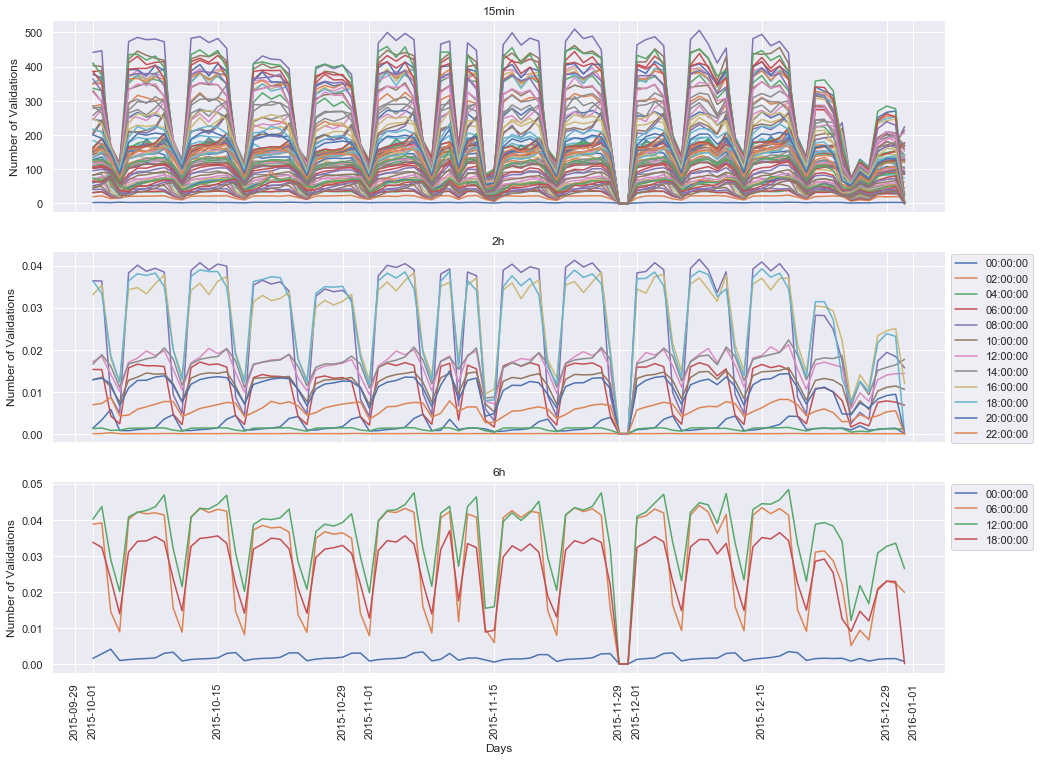

In [16]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dtmatrix_mean_15m.plot(ax=ax[0], legend=False)
ax1.set_xticklabels([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('15min')

ax2 = dtmatrix_mean_2h.plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Number of Validations')
ax2.set_title('2h')
ax2.legend(bbox_to_anchor=(1., 1.01))

ax3 = dtmatrix_mean_6h.plot(ax=ax[2])
ax3.set_xlabel('Days')
ax3.set_ylabel('Number of Validations')
ax3.set_title('6h')
ax3.legend(bbox_to_anchor=(1., 1.01))

plt.xticks(rotation=90)
plt.show();

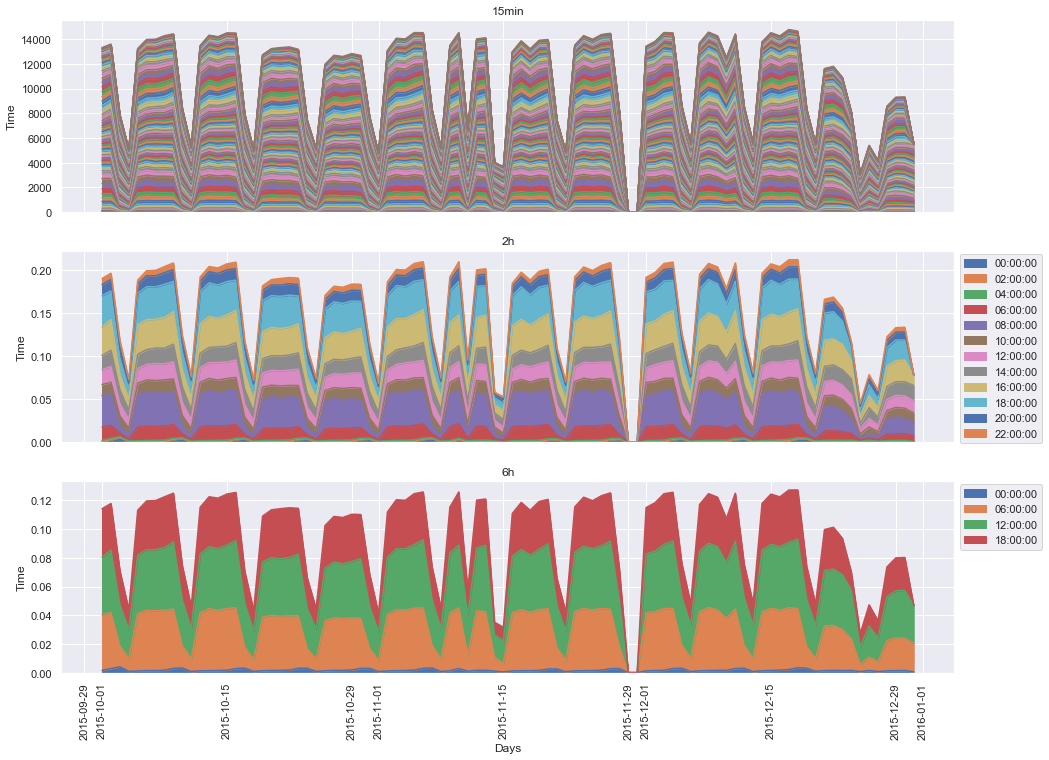

In [17]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dtmatrix_mean_15m.plot.area(ax=ax[0], legend=False)
ax1.set_xticklabels([])
ax1.set_ylabel('Time')
ax1.set_title('15min')

ax2 = dtmatrix_mean_2h.plot.area(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Time')
ax2.set_title('2h')
ax2.legend(bbox_to_anchor=(1., 1.01))

ax3 = dtmatrix_mean_6h.plot.area(ax=ax[2])
ax3.set_xlabel('Days')
ax3.set_ylabel('Time')
ax3.set_title('6h')
ax3.legend(bbox_to_anchor=(1., 1.01), loc=2)

plt.xticks(rotation=90)
plt.show();

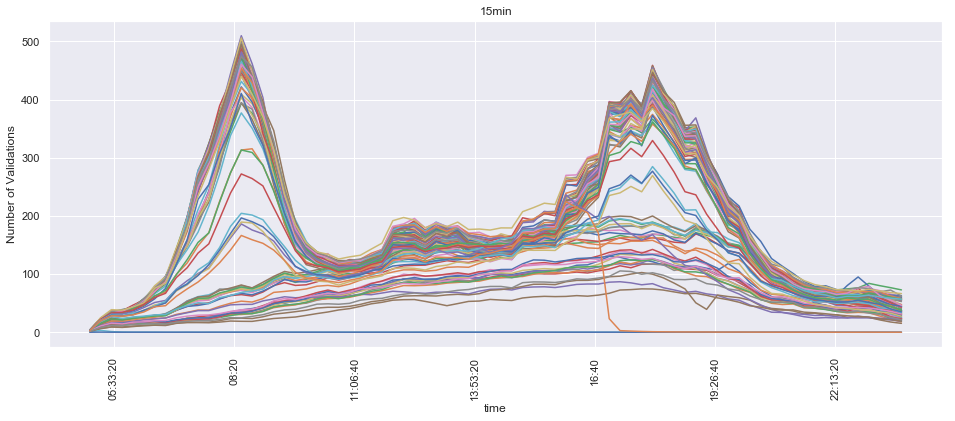

In [18]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])
dmatrix_mean_15m.plot(ax=ax, legend=False)
plt.ylabel('Number of Validations')
plt.title('15min')

plt.xticks(rotation=90)
plt.show();

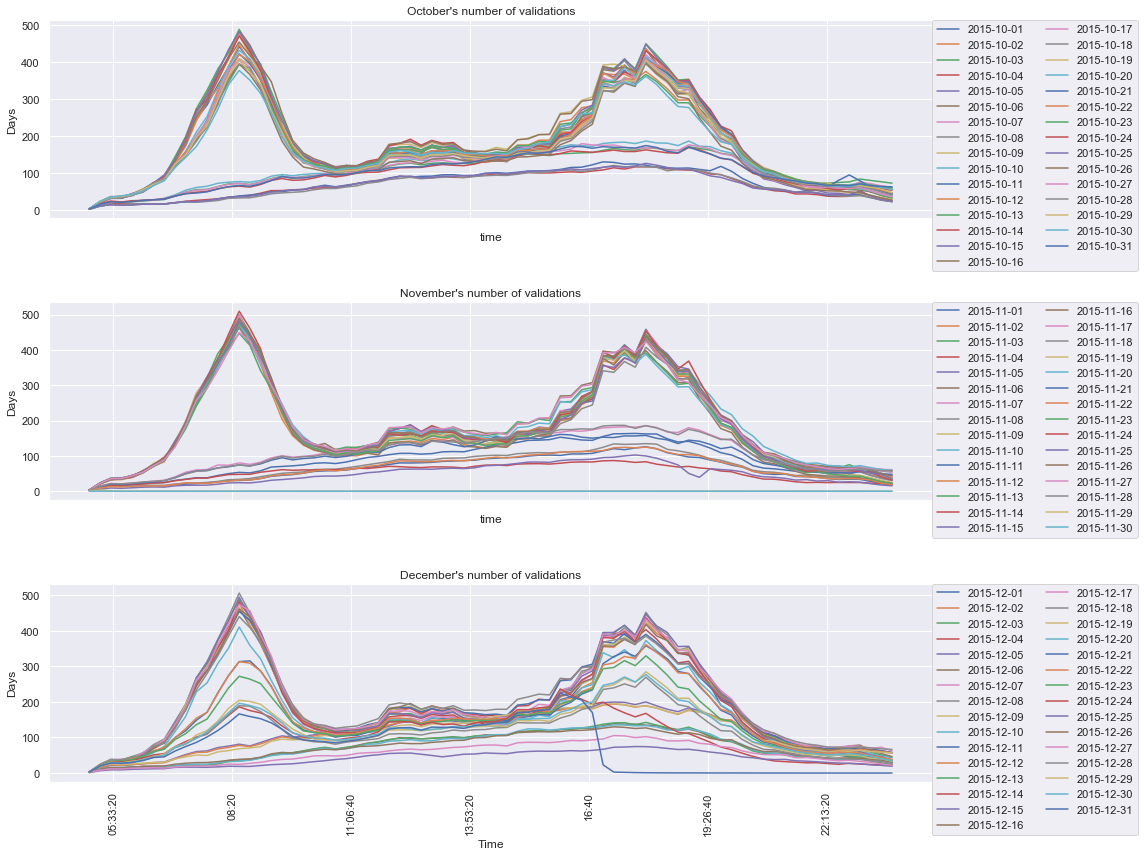

In [19]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dmatrix_mean_15m.iloc[:, :31].plot(ax=ax[0])
ax1.set_xticklabels([])
ax1.set_ylabel('Days')
ax1.set_title('October\'s number of validations')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)


ax2 = dmatrix_mean_15m.iloc[:, 31:61].plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Days')
ax2.set_title('November\'s number of validations')
ax2.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax3 = dmatrix_mean_15m.iloc[:, 61:].plot(ax=ax[2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Days')
ax3.set_title('December\'s number of validations')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

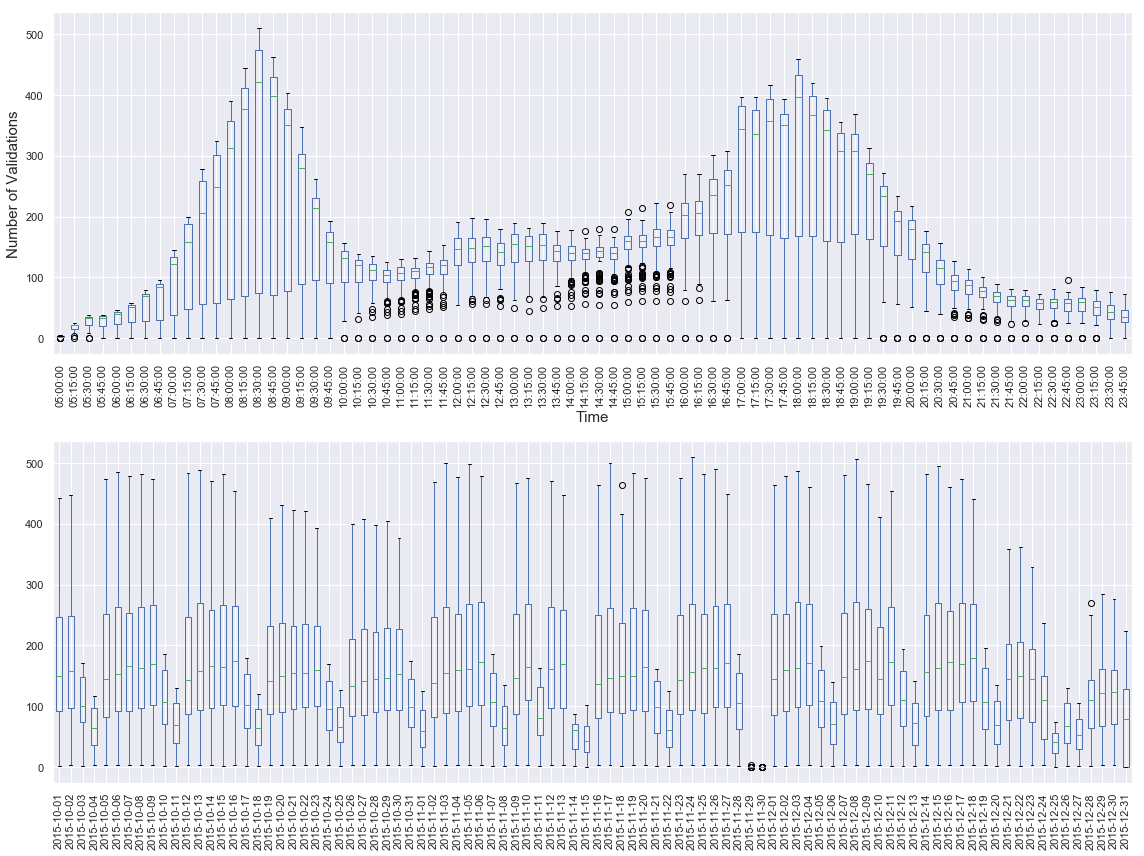

In [20]:
f, ax = plt.subplots(2, figsize=(16, 12))

ax1 = dtmatrix_mean_15m.boxplot(return_type='both', ax=ax[0])
ax[0].set_xlabel("Time", fontsize=15)
ax[0].set_ylabel("Number of Validations", fontsize=15)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

ax2 = dmatrix_mean_15m.boxplot(return_type='both', ax=ax[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

### Defining useful variables

In [21]:
def sep_days(dico, diff_days=7):
    """ 
    
    :param dico:
    :param diff_days:
    :return:
    :rtype:
    
    """
    
    return {d: dict(filter(lambda dd: dd[1].weekday() == d,
                        zip(dico, dico.values())))
              for d in range(diff_days)}


def sep_wde(dico, week="days"):
    """
    
    :param dico:
    :param week:
    :return:
    :rtype:
    
    """

    if week.lower() == "days":
        return dict(filter(lambda dd: dd[1].weekday() < 5, 
                        zip(dico, dico.values())))
    elif week.lower() == "end":
        return dict(filter(lambda dd: dd[1].weekday() >= 5, 
                        zip(dico, dico.values())))
    else:
        raise ValueError("Wrong value for parameter \"week\"\n \
        Only takes two differents values : \"days\" or \"end\"")

def sep_month(dico, month_num=10):
    """
    
    :param dico:
    :param month_num:
    :return:
    :rtype:
    
    """
    
    return dict(filter(lambda dd: dd[1].month == month_num, 
                       zip(dico, dico.values())))


def remove_anomalies(dico, anomalies):
    """
    
    :param dico:
    :param anomalies:
    :return:
    :rtype:
    
    """
    
    return dict(filter(lambda dd: dd[1] not in anomalies,
                       zip(dico, dico.values())))


In [22]:
dict_dates = { i: d for i, d in zip(range(len(dates)), dates)}
ddict_days = sep_days(dict_dates, diff_days=7)

dict_wd = sep_wde(dict_dates, week="days")
dict_we = sep_wde(dict_dates, week="end")

dict_wd_oct = sep_month(dict_wd, 10)
dict_wd_nov = sep_month(dict_wd, 11)
dict_wd_dec = sep_month(dict_wd, 12)

nov_del = [date(2015, 11, 11), date(2015, 11, 29), date(2015, 11, 30)]
vacs = pd.date_range(start="2015-12-21", end="2015-12-31").date.tolist()
to_del = nov_del + vacs

dict_w = remove_anomalies(dict_dates, to_del)
dict_wd_final = remove_anomalies(dict_wd, to_del)                         

dict_wd_octf = sep_month(dict_wd_final, 10)
dict_wd_novf = sep_month(dict_wd_final, 11)
dict_wd_decf = sep_month(dict_wd_final, 12)

In [23]:
wd_15m = data_matrix_15m.loc[dict_w.values()]
wdm_15m = wd_15m.mean()
wdmt_15m = wdm_15m.transpose()

wd_15mf = data_matrix_15m.loc[dict_wd_final.values()]
wdm_15mf = wd_15mf.mean()
wdmt_15mf = wdm_15mf.transpose()

### Without outliers

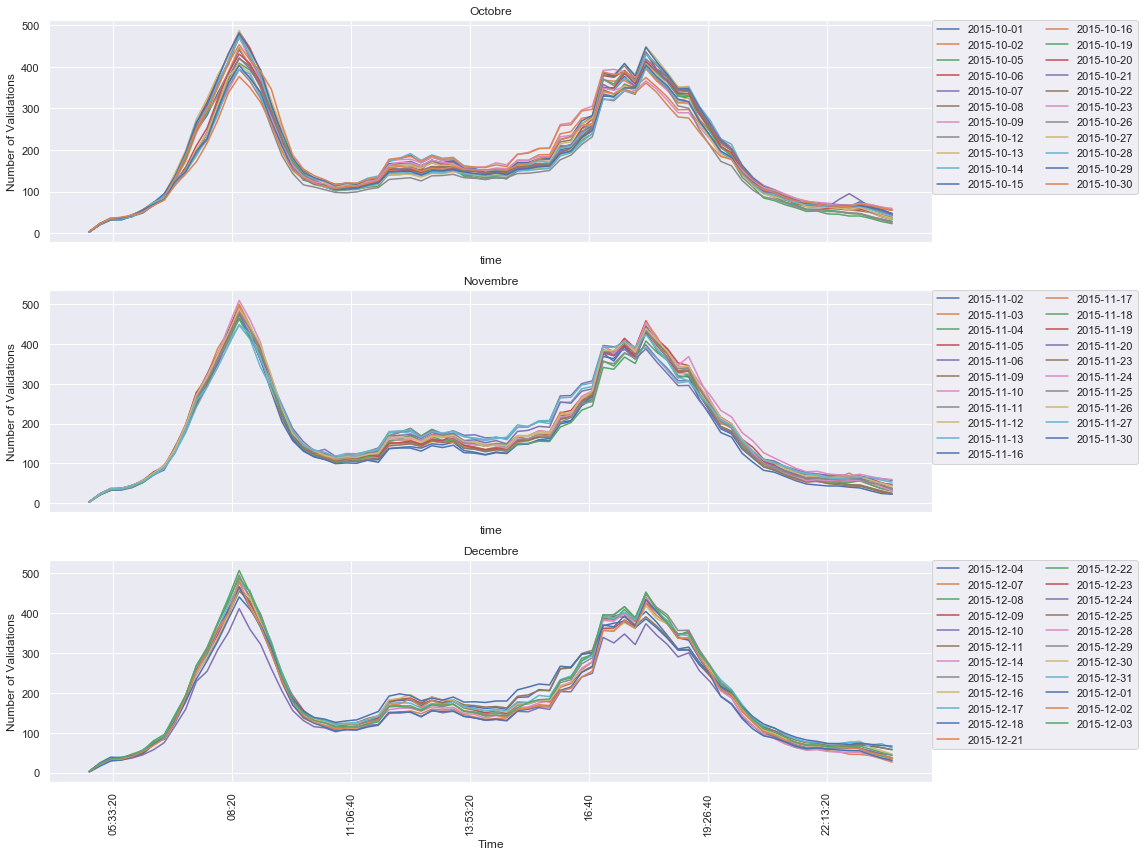

In [24]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = wdm_15m.loc[:, dict_wd_oct.values()].plot(ax=ax[0])
ax1.set_xticklabels([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('Octobre')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)


ax2 = wdm_15m.loc[:, dict_wd_nov.values()].plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Number of Validations')
ax2.set_title('Novembre')
ax2.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax3 = wdm_15m.loc[:, dict_wd_dec.values()].plot(ax=ax[2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Number of Validations')
ax3.set_title('Decembre')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

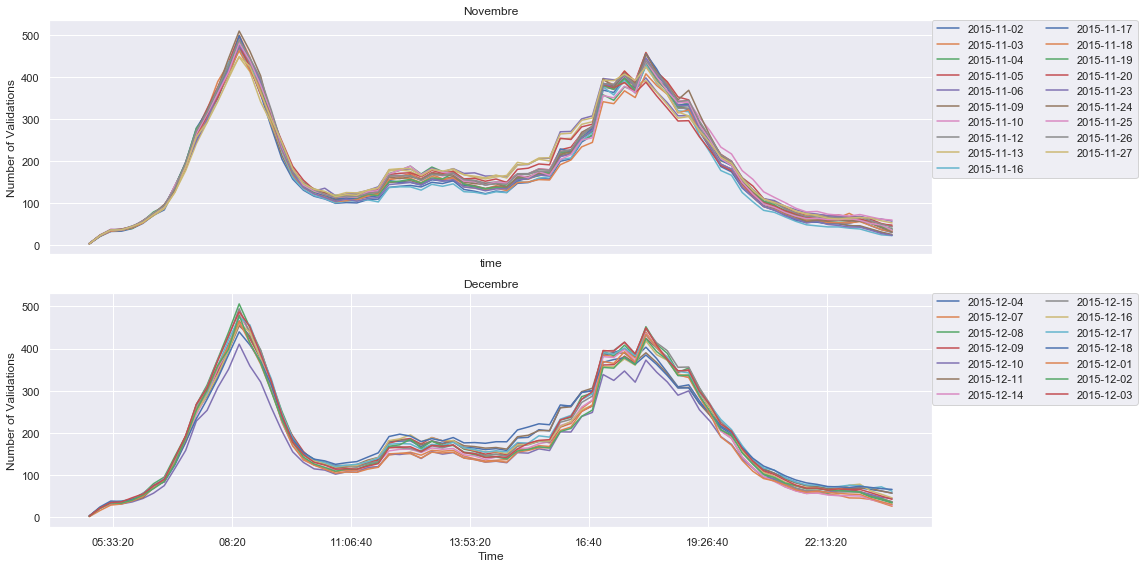

In [25]:
f, ax = plt.subplots(2, figsize=(16, 8))

ax1 = wdm_15mf.loc[:, dict_wd_novf.values()].plot(ax=ax[0])
ax1.set_xticks([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('Novembre')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax2 = wdm_15mf.loc[:, dict_wd_decf.values()].plot(ax=ax[1])
ax2.set_xlabel('Time')
ax2.set_ylabel('Number of Validations')
ax2.set_title('Decembre')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)
plt.tight_layout()

plt.show();

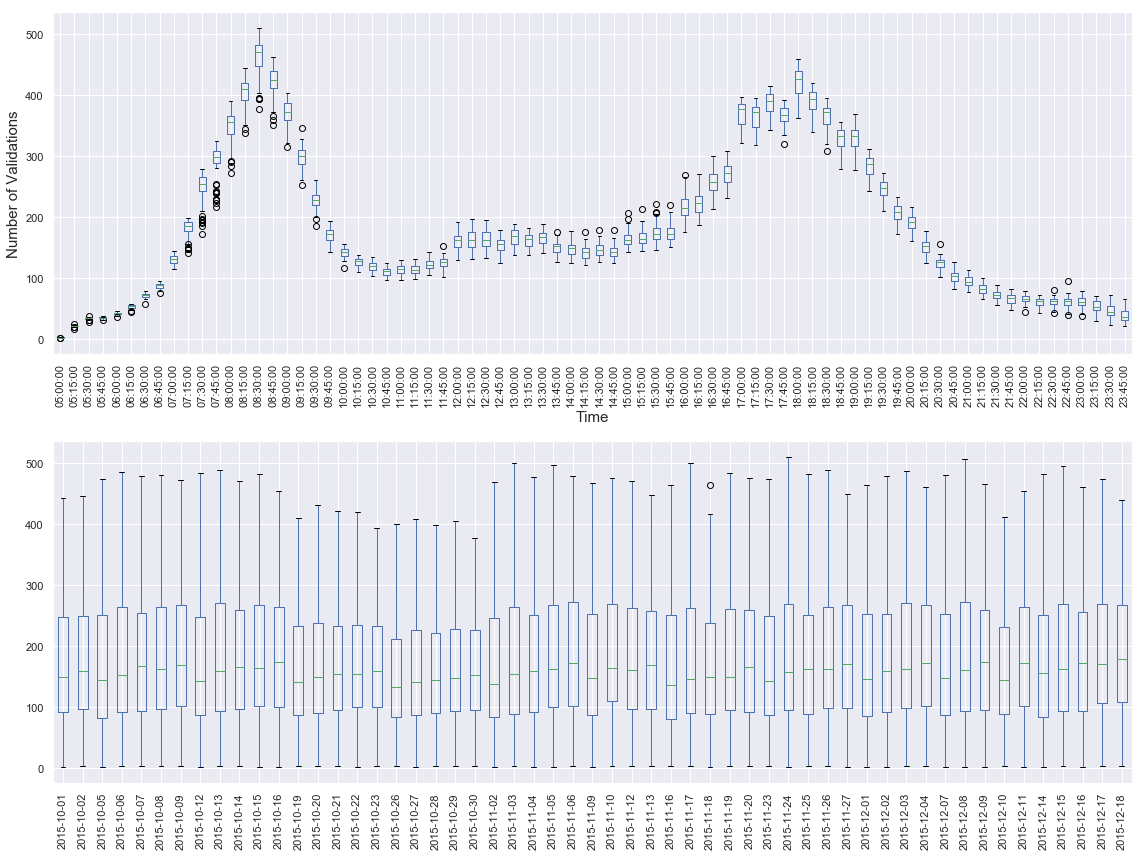

In [26]:
f, ax = plt.subplots(2, figsize=(16, 12))

ax1 = wdmt_15mf.boxplot(return_type='both', ax=ax[0])
ax[0].set_xlabel("Time", fontsize=15)
ax[0].set_ylabel("Number of Validations", fontsize=15)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

ax2 = wdm_15mf.boxplot(return_type='both', ax=ax[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

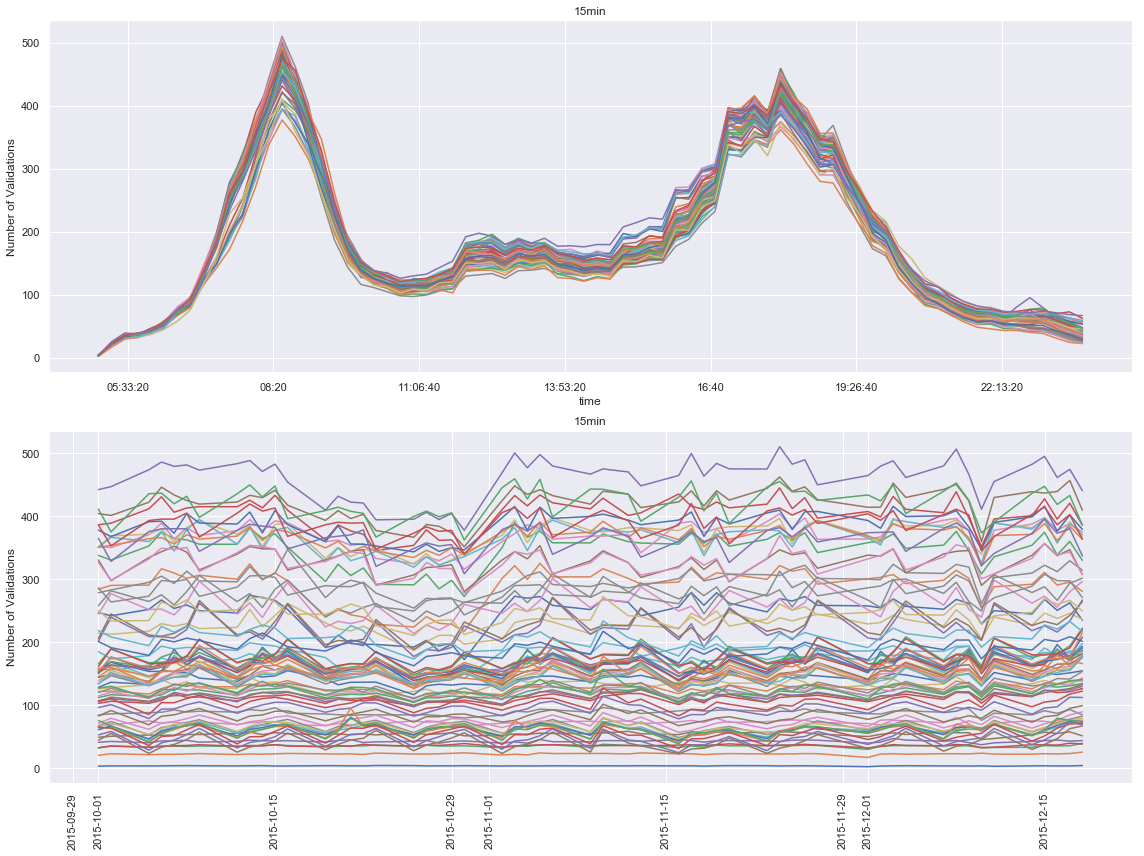

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 12))

wdm_15mf.plot(ax=ax1, legend=False)
ax1.set_ylabel('Number of Validations'); ax1.set_title('15min')

ax2 = wdmt_15mf.plot(ax=ax2, legend=False)
ax2.set_ylabel('Number of Validations'); ax2.set_title('15min')

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

### Autocorrelation Plots

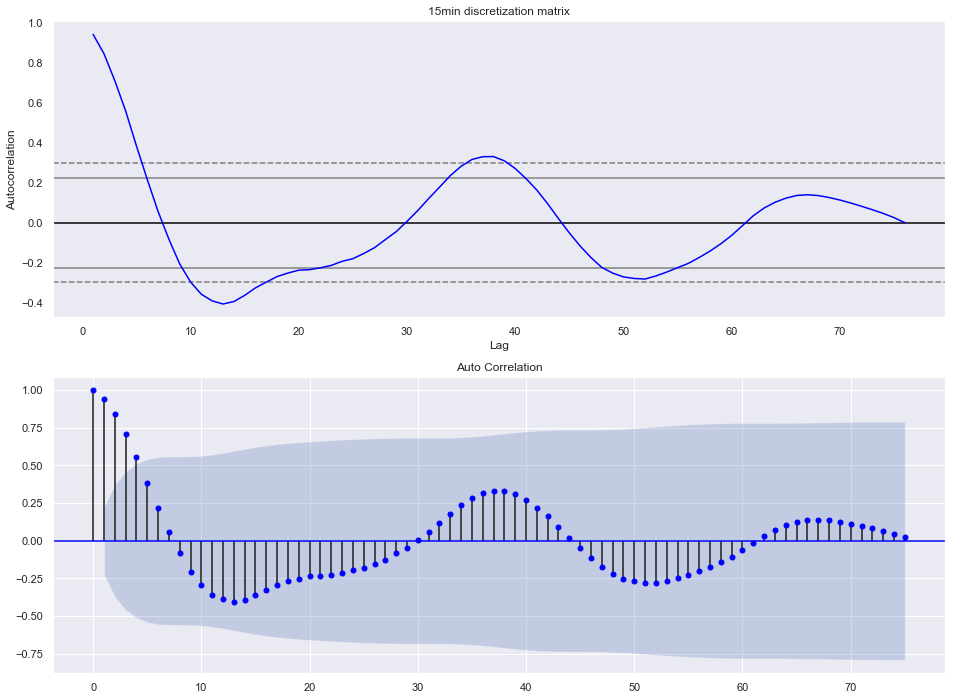

In [28]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 12))

autocorrelation_plot(wdmt_15mf.mean(), ax=ax1, c='blue')
ax1.set_title('15min discretization matrix')

plot_acf(wdmt_15mf.mean(), ax=ax2, c='blue', title='Auto Correlation')

plt.show();

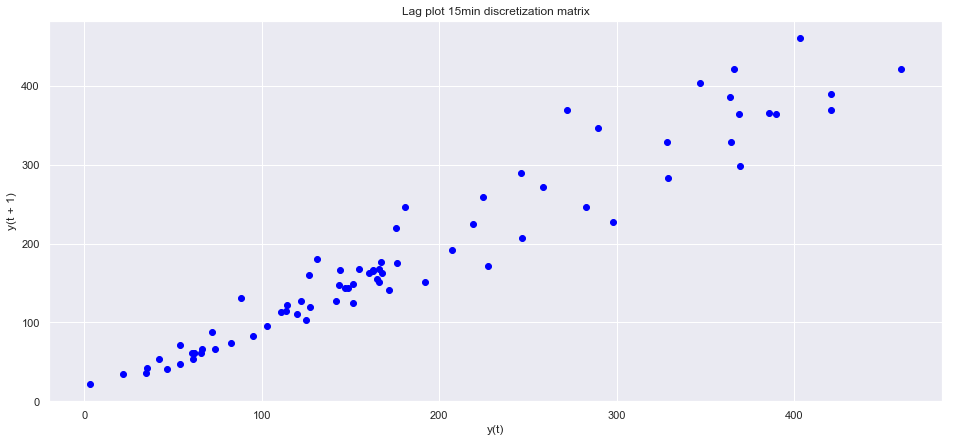

In [29]:
plt.figure(figsize=(16, 7))

lag_plot(wdmt_15mf.mean(), c='blue')
plt.title('Lag plot 15min discretization matrix')

# plot_pacf(wdmt_15mf.mean(), ax=ax[1], c='blue', title='Partial Auto Correlation')

plt.show();

### Splitting Data into Train and Test

In [30]:
dico = dict_w
size = 50

In [31]:
X = data_matrix_15m.loc[dico.values()]
Xm = X.mean()
Xmt = Xm.transpose()

In [32]:
kw = list(dico.keys())
np.random.shuffle(kw)

vw = [dico[i] for i in kw]

In [33]:
ind_train = vw[:size]
ind_test = vw[size:]
X_train = X[ind_train]
X_test = X[ind_test]

In [34]:
X_train
X_test

<class 'pandas.core.panel.Panel'>
Dimensions: 50 (items) x 303 (major_axis) x 76 (minor_axis)
Items axis: 2015-10-16 to 2015-10-15
Major_axis axis: 198 to 60982
Minor_axis axis: 05:00:00 to 23:45:00

<class 'pandas.core.panel.Panel'>
Dimensions: 28 (items) x 303 (major_axis) x 76 (minor_axis)
Items axis: 2015-11-18 to 2015-10-12
Major_axis axis: 198 to 60982
Minor_axis axis: 05:00:00 to 23:45:00

## Models

In [50]:
class Regressor:
    def __init__(self):
        raise NotImplementedError("Please Implement this method")
        
    def datax_decorator(fonc):
        def reshape_data(self, datax, *args, **kwargs):
            """ Reshape data into one single matrix in order to apply analytic
            solution.

            :param datax: contient tous les exemples du dataset
            :returns: void
            :rtype: None

            """
            
            if datax.ndim == 3:
                X = datax.iloc[:, :, 0:self.order].values.reshape(-1, self.order)
                y = datax.iloc[:, :, self.order].values.T.reshape(-1, 1)
                for t in range(1, datax.shape[2] - self.order):
                    X = np.vstack((
                        X, 
                        datax.iloc[:, :, t:t+self.order].values.reshape(-1, self.order)))
                    y = np.vstack((
                        y, 
                        datax.iloc[:, :, t+self.order].values.T.reshape(-1, 1)))

                return fonc(self, (X, y), *args, **kwargs)
            elif datax.ndim == 2:
                X = datax.iloc[:, 0:self.order].values.reshape(-1, self.order)
                y = datax.iloc[:, self.order].values.reshape(-1, 1)
                for t in range(1, datax.shape[1] - self.order):
                    X = np.vstack((
                        X, 
                        datax.iloc[:, t:t+self.order].values.reshape(-1, self.order)))
                    y = np.vstack((y, 
                                   datax.iloc[:, t+self.order].values.reshape(-1, 1)))

                return fonc(self, (X, y), *args, **kwargs)
            elif datax.ndim == 1:
                # TODO 
                pass
            else:
                raise ValueError("Untreated datax number of dimensions")
        
        return reshape_data    
        
    def fit(self):
        raise NotImplementedError("Please Implement this method")
        
    def predict(self):
        raise NotImplementedError("Please Implement this method")
        
    def score(self):
        raise NotImplementedError("Please Implement this method")

### Baseline

In [51]:
class Baseline:
    def __init__(self, level=None, first_ndays=7):
        """ Initialization of Baseline parameters
        
        :param level: level of computing, means : if level is None the rmse is
        computed on the whole Train Set, if level is equal to "S", then the 
        metric is applied separatly for each station, if it is equal to "J", 
        it is applied separetly for each day : Lundi, Mardi, etc..., if it is
        equal to "SJ", then for each station and each day, we aggregate the
        values and compute the metric. And if level is none of the listed
        values above then, we consider that it is None, by default.
        
        :param first_ndays:
        :return:
        :rtype:
        
        """
        
        self.first_ndays = first_ndays
        self.level = level
        if self.level not in [None, "s", "S", "j", "J", "sj", "SJ", "Sj", "sJ"]:
            self.level = None   
        
    def fit(self, datax):
        """
        
        """
        
        if self.level is None:
            self.mean = datax.mean().mean(axis=1)
        elif self.level.lower() == "s":
            self.mean = datax.mean(axis=0)
        elif self.level.lower() == "j":
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean().mean(axis=1))                
        elif self.level.lower() == "sj":
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean(axis=0))
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
    
    
    def predict(self, datax):
        """
        
        """
        
        if self.level is None:
            return datax.apply(lambda x: self.mean, axis="minor")        
        
        elif self.level.lower() == "s":
            return datax.apply(lambda x: self.mean, axis=(1, 2))
        
        elif self.level.lower() == "j":
            datax_copy = datax.copy()
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                # print(exist_ind, "\n")
                datax_copy.update(datax_copy[exist_ind].apply(
                    lambda x: self.mean[d], axis="minor"))
                
            return datax_copy
        
        elif self.level.lower() == "sj":
            datax_copy = datax.copy()
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                datax_copy.update(datax_copy[exist_ind].apply(
                    lambda x: self.mean[d], axis=(1, 2))) 
                
            return datax_copy
        
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
          
            
    def score(self, datax):
        """
        
        """
        
        return np.sqrt(((datax.values - self.predict(datax).values)**2).mean())

In [52]:
limit_t = 10
levels = ["None", "s", "j", "sj"]
baseline_scores = []
baseline_preds = []
for level in levels:
    b = Baseline(level=level, first_ndays=7)
    b.fit(X_train)
    baseline_preds.append(b.predict(X_test))
    baseline_scores.append(np.array([b.score(X_test)]).repeat(limit_t))

In [53]:
pd_baseline = pd.DataFrame(np.array(baseline_scores), index=levels, columns=range(limit_t))

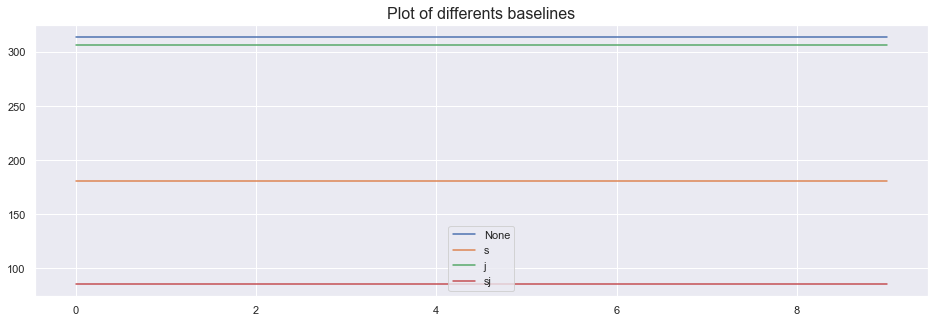

In [54]:
pd_baseline.T.plot(figsize=(16, 5))
plt.title("Plot of differents baselines", fontsize=16);

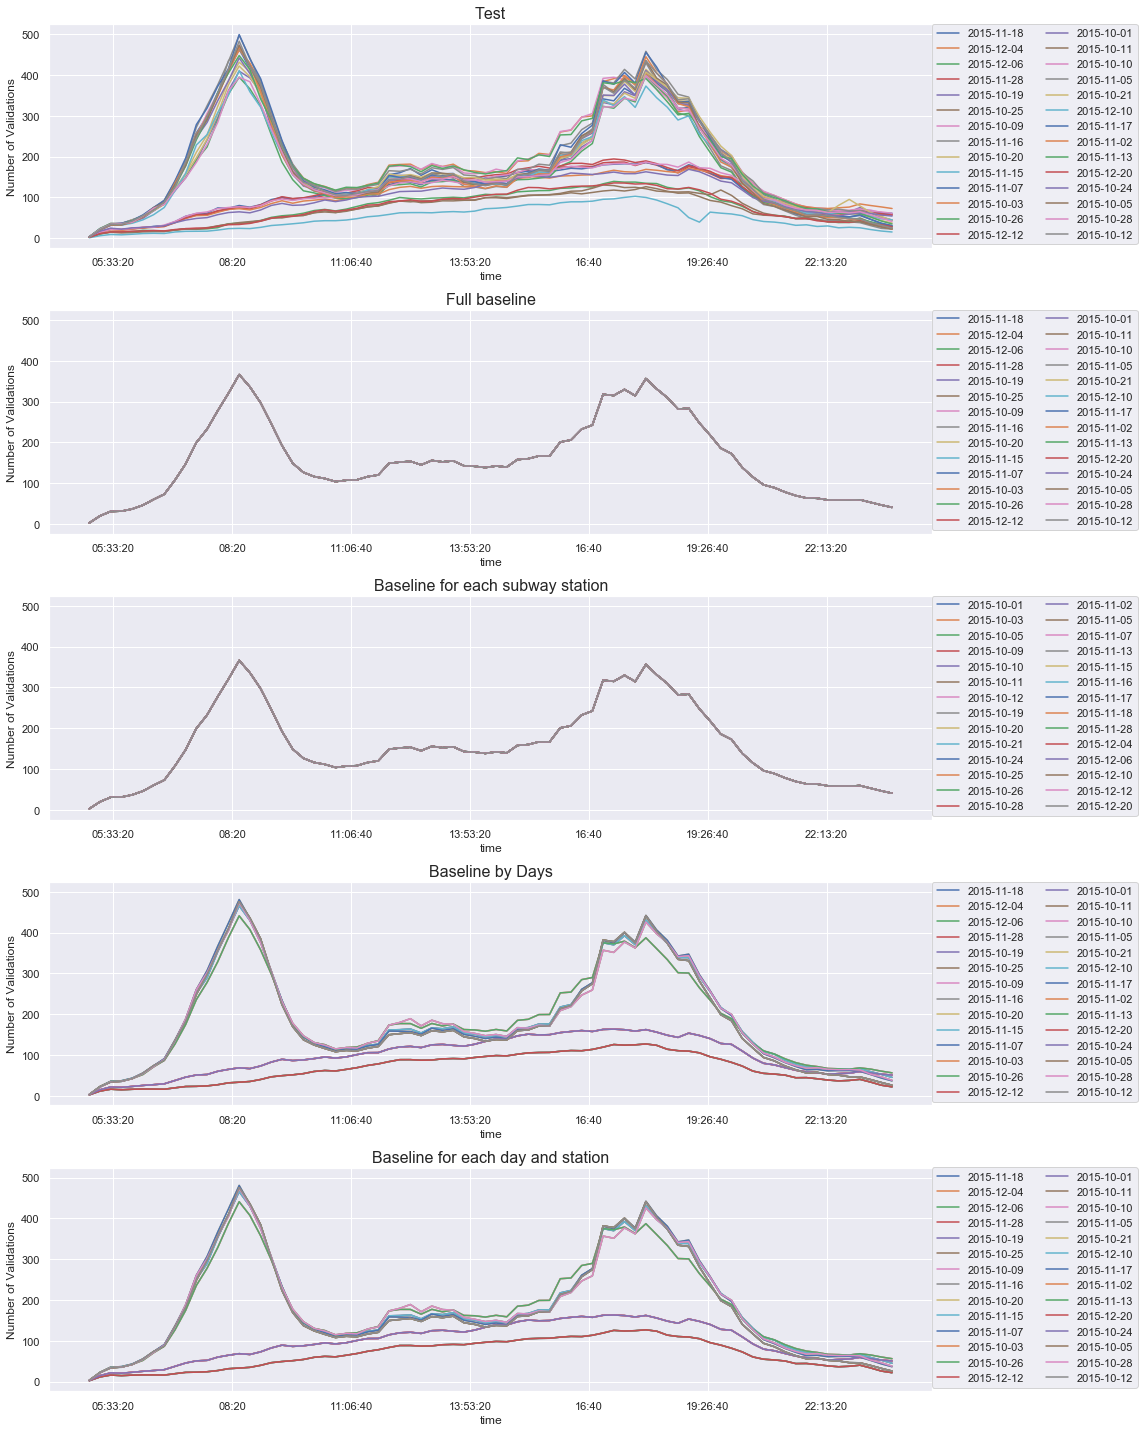

In [55]:
fig, ax = plt.subplots(5, figsize=(16, 20))

X_test.mean().plot(ax=ax[0])
ax[0].set_ylabel('Number of Validations')
ax[0].set_title('Test', fontsize=16)
ax[0].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

baseline_preds[0].mean().plot(ax=ax[1])
ax[1].set_ylabel('Number of Validations')
ax[1].set_title('Full baseline', fontsize=16)
ax[1].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)
ax[1].set_ylim(*ax[0].get_ylim())

baseline_preds[1].mean().plot(ax=ax[2])
ax[2].set_ylabel('Number of Validations')
ax[2].set_title('Baseline for each subway station', fontsize=16)
ax[2].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)
ax[2].set_ylim(*ax[0].get_ylim())

baseline_preds[2].mean().plot(ax=ax[3])
ax[3].set_ylabel('Number of Validations')
ax[3].set_title('Baseline by Days', fontsize=16)
ax[3].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)
ax[3].set_ylim(*ax[0].get_ylim())

baseline_preds[3].mean().plot(ax=ax[4])
ax[4].set_ylabel('Number of Validations')
ax[4].set_title('Baseline for each day and station', fontsize=16)
ax[4].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)
ax[4].set_ylim(*ax[0].get_ylim())

plt.tight_layout()
plt.show();

In [56]:
from cost_functions import mse, mse_g


class myAR(Regressor):
    def __init__(self, order=4, level=None, loss=mse, loss_g=mse_g, max_iter=1000,
                 eps=0.01):
        """ Initialisation des paramètres du perceptron

        :param order: Taille de la fenêtre glissante
        :param loss: fonction de coût
        :param loss_g: gradient de la fonction coût
        :param max_iter: nombre maximum d'itération de la fonction coût
        :param eps: pas du gradient


        """

        self.order = order
        self.max_iter, self.eps = max_iter, eps
        self.loss, self.loss_g = loss, loss_g
        self.w = np.random.random(self.order)
                      
    
    @Regressor.datax_decorator
    def analytic_fit(self, datax):
        """ Finds the optimal weigths analytically 
        
        :param datax: contient tous les exemples du dataset
        :returns: void
        :rtype: None
        
        """
        
        self.X, self.y = datax
        A, B = self.X.T.dot(self.X), self.X.T.dot(self.y)
        self.w = np.linalg.solve(A, B).ravel()
        
        # display(HTML(pd.DataFrame(self.w.reshape(1, -1), index=['Weights'], 
        #                           columns=range(len(self.w))).to_html()))
       
    
    def minibatch_fit(self, datax):
        """ Mini-Batch gradient descent Learning

        :param datax: contient tous les exemples du dataset
        
        """

        for _ in range(self.max_iter):
            for d in range(datax.shape[0]):
                for t in range(datax.shape[2] - self.order):
                    batchx = datax.iloc[d, :, t:t + self.order].values
                    batchy = datax.iloc[d, :, t + self.order].values
                    self.w -= (self.eps * self.loss_g(batchx, batchy, self.w))
                    
        
        # display(HTML(pd.DataFrame(self.w.reshape(1, -1), index=['Weights'], 
        #                          columns=range(len(self.w))).to_html()))

    def predict(self, datax):
        """ Predict labels

        :param datax: contient tous les exemples du dataset
        :returns: predicted labels
        :rtype: numpy array

        """

        y_pred = []
        for d in range(datax.shape[0]):
            y_pred.append([])
            for t in range(datax.shape[2] - self.order):
                batchx = datax.iloc[d, :, t:t + self.order].values
                y_pred[d].append(batchx.dot(self.w.T))

        return np.array(y_pred).transpose(0, 2, 1)

    def forecast_n(self, datax):
        """ Predict labels

        :param datax: contient tous les exemples du dataset
        :returns: predicted labels
        :rtype: numpy array

        """

        y_pred = []
        for d in range(datax.shape[0]):
            y_pred.append([])
            batchx = datax.iloc[d, :, 0:self.order].values
            for t in range(datax.shape[2] - self.order):
                next_y = batchx.dot(self.w.T)
                y_pred[d].append(next_y)
                batchx = np.hstack(
                    (batchx[:, 1:], np.array(next_y).reshape(-1, 1)))

        return np.array(y_pred).transpose(0, 2, 1)
    
    def forecast(self, datax, tplus=None):
        """ Predict labels

        :param datax: contient tous les exemples du dataset
        :param tplus: if t equal to 2, means predicting what happened at t+2
        :returns: predicted labels
        :rtype: numpy array
        
        """
                
        if tplus == None or tplus > self.order:
            return self.forecast_n(datax)
        else:
            y_pred = []
            replace_static_index = self.order - tplus
            
            if datax.ndim == 3:                
                for d in range(datax.shape[0]):
                    y_pred.append([])
                    batchx = datax.iloc[d, :, 0:self.order].values                
                    for t in range(datax.shape[2] - self.order):
                        next_y = batchx.dot(self.w.T)
                        next_y = np.where(next_y < 0, 0, next_y)
                        y_pred[d].append(next_y)
                        batchx = np.hstack(
                            (batchx[:, 1:], np.array(next_y).reshape(-1, 1)))
                        replace_ind = replace_static_index + t + 1
                        batch_ind = self.order - tplus
                        batchx[:, batch_ind] = datax.iloc[d, :, replace_ind].values
            elif datax.ndim == 2:
                # TODO
                pass
            elif datax.ndim == 1:
                batchx = datax.iloc[0:self.order].values
                # y_pred = batchx.tolist()
                for t in range(datax.shape[0] - self.order): 
                    next_y = batchx.dot(self.w.T)
                    if next_y < 0: next_y = 0
                    y_pred.append(next_y)
                    batchx = np.hstack((batchx[1:], next_y))
                    replace_ind = replace_static_index + t + 1
                    batch_ind = self.order - tplus
                    batchx[batch_ind] = datax.iloc[replace_ind]
                    
                return np.array(y_pred)
            else:
                raise ValueError("Untreated datax number of dimensions")
                                        
        return np.array(y_pred).transpose(0, 2, 1)
    

In [57]:
class theAR(Baseline):
    def __init__(self, level=None, first_ndays=7, **kwargs):
        """
        
        """
        
        super().__init__(level, first_ndays)
        self.kwargs = kwargs
        
    def fit(self, datax):
        """
        
        """
        
        if self.level is None:
            self.model = myAR(**self.kwargs)
            self.model.analytic_fit(datax)
        elif self.level.lower() == "s":
            self.models = []            
            for s in range(datax.shape[1]):
                Xs = datax.iloc[:, s].T
                self.models.append(myAR(**self.kwargs))
                self.models[s].analytic_fit(Xs)
        elif self.level.lower() == "j":
            # TODO
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean().mean(axis=1))                
        elif self.level.lower() == "sj":
            # TODO
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean(axis=0))
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
    
    
    def predict(self, datax, tplus=None):
        """
        
        """
        
        def predict_per_station(x, tplus):
            pred_s = []
            for s in range(x.shape[0]):
                pred_s.append(self.models[s].forecast(x.iloc[s], tplus))
            return np.array(pred_s)
        
        if self.level is None:
            return self.model.forecast(datax, tplus)
        elif self.level.lower() == "s":
            return datax.apply(
                lambda x: predict_per_station(x, tplus), axis=(1, 2))
        elif self.level.lower() == "j":
            # TODO
            pass
        elif self.level.lower() == "sj":
            # TODO
            pass
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
    
    
    def score(self, datax, tplus=None):
        """
        
        """
        
        X_pred = self.predict(datax, tplus)
        
        try:
            return np.sqrt(((X_pred - 
                         datax.iloc[:, :, self.model.order:].values)**2).mean())
        except:
            return np.sqrt(((X_pred.values - 
                         datax.iloc[:, :, self.models[0].order:].values)**2).mean())

    

In [58]:
def ar_plot_results(level, order, limit_t):
    """
    
    """
    
    ar_scores = []
    ar_preds = []
    for t in range(1, limit_t+1):
        ar = theAR(level=level, order=order)
        ar.fit(X_train)
        ar_preds.append(ar.predict(X_test, t))
        ar_scores.append(ar.score(X_test, t))
        
    return ar_scores, ar_preds


### One AR for all

In [82]:
order = 4
limit_t = 4

In [83]:
%%time
ar_scores, ar_preds = ar_plot_results(None, order, limit_t)

CPU times: user 8.91 s, sys: 2.89 s, total: 11.8 s
Wall time: 11.4 s


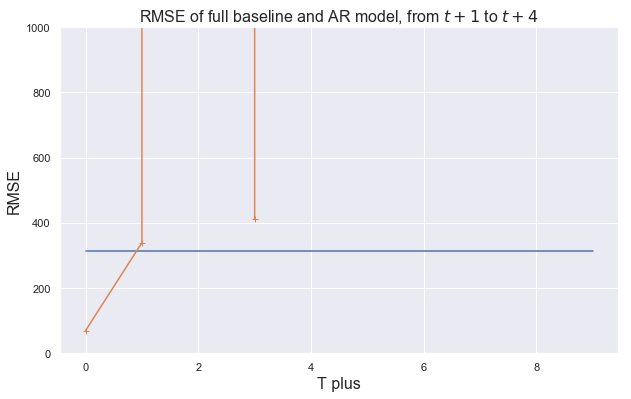

In [84]:
plt.figure(figsize=(10, 6))
pd_baseline.iloc[0].plot(figsize=(10, 6))
plt.plot(range(len(ar_scores)), ar_scores, marker='+')
plt.ylim(0, 1000)
plt.title("RMSE of full baseline and AR model, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

In [85]:
wd_testorder_15m = X_test.iloc[:, :, order:]
wdm_testorder_15m = wd_testorder_15m.mean()
wdmt_testorder_15m = wdm_testorder_15m.transpose()

In [86]:
def create_panel_pred(ar_preds, t, order, del_hours=0):
    """
    
    """
    
    return pd.Panel(np.array(ar_preds[t-1]),
                      items=wd_testorder_15m.items, 
                      major_axis=subway_stations, 
                      minor_axis=generate_times("15min")[(del_hours*4)+order:]
                     )

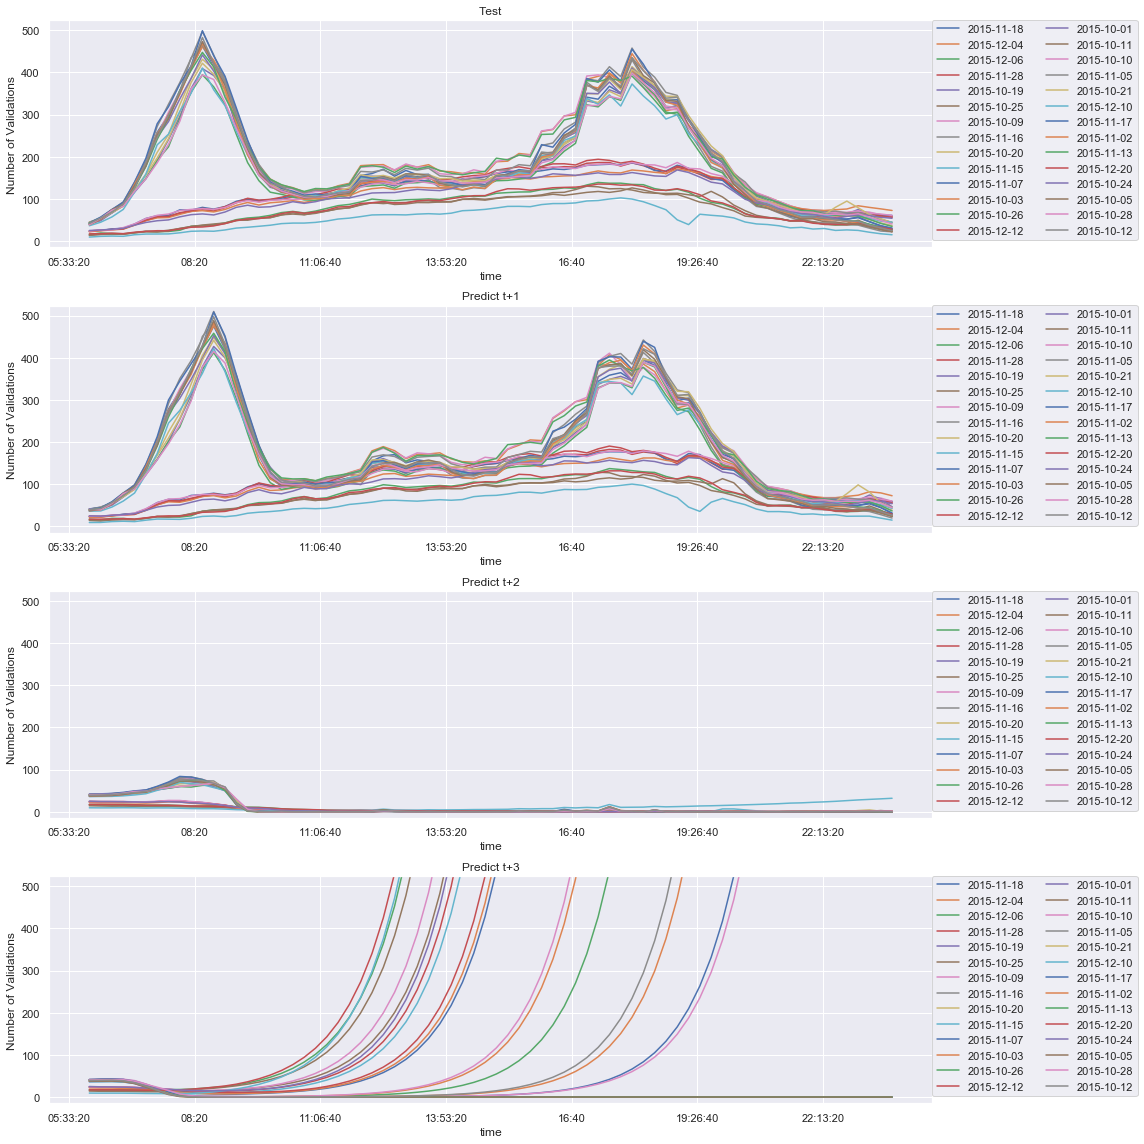

In [92]:
fig, ax = plt.subplots(limit_t, figsize=(16, limit_t*4))

wdm_testorder_15m.plot(ax=ax[0])
ax[0].set_ylabel('Number of Validations')
ax[0].set_title('Test')
ax[0].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

for i in range(1, limit_t):
    pred_t = create_panel_pred(ar_preds, i, order=order, del_hours=5).mean()
    pred_t.plot(ax=ax[i])
    ax[i].set_ylabel('Number of Validations')
    ax[i].set_title("Predict t+{}".format(i))
    ax[i].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
                 borderaxespad=0.)
    ax[i].set_ylim(*ax[0].get_ylim())



plt.tight_layout()
plt.show();

### AR per station

In [93]:
ars_scores, ars_preds = ar_plot_results("s", order, limit_t)

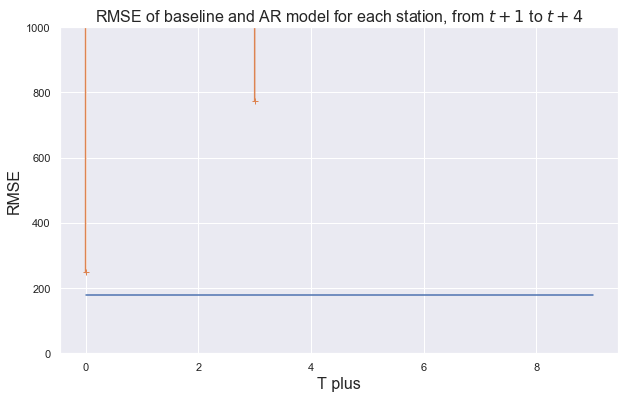

In [94]:
pd_baseline.iloc[1].plot(figsize=(10, 6))
plt.plot(range(len(ars_scores)), ars_scores, marker='+')
plt.ylim(0, 1000)
plt.title("RMSE of baseline and AR model for each station, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

IndexError: index 4 is out of bounds for axis 0 with size 4

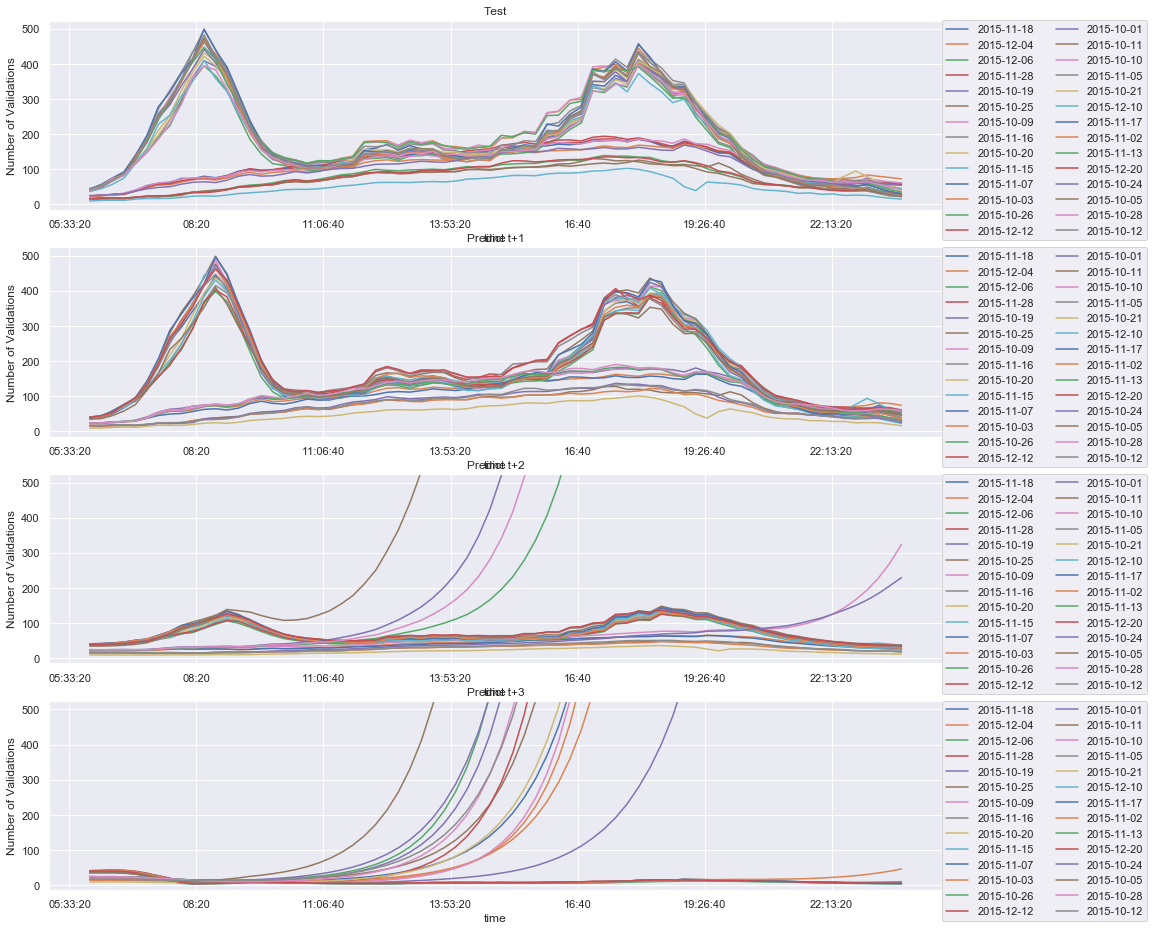

In [95]:
fig, ax = plt.subplots(limit_t, figsize=(16, limit_t*4))

wdm_testorder_15m.plot(ax=ax[0])
ax[0].set_ylabel('Number of Validations')
ax[0].set_title('Test')
ax[0].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

for i in range(1, 8):
    pred_t = create_panel_pred(ars_preds, i, order=order, del_hours=5).mean()
    pred_t.plot(ax=ax[i])
    ax[i].set_ylabel('Number of Validations')
    ax[i].set_title("Predict t+{}".format(i))
    ax[i].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
                 borderaxespad=0.)
    ax[i].set_ylim(*ax[0].get_ylim())



plt.tight_layout()
plt.show();

## Brouillon 